In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape
input_layer = tf.keras.layers.Input(shape=(inputShape))
numClasses = len(bbdc.LABEL_DICT)

24009it [01:51, 214.45it/s]
3047it [00:11, 269.53it/s]
2988it [00:11, 268.79it/s]


In [4]:
channels = [32, 64, 90]
modelsForSingleClasses = [unet.u_net(None, channels, lessParameter = True, numClasses=2, inputLayer = input_layer) for i in range(numClasses)]

In [5]:
Y_train_classes = [np.expand_dims(Y_train[:,:,i], axis=-1) for i in range(numClasses)]
Y_train_classes = [np.append(y, 1-y, axis=-1) for y in Y_train_classes]

Y_validation_classes = [np.expand_dims(Y_validation[:,:,i], axis=-1) for i in range(numClasses)]
Y_validation_classes = [np.append(y, 1-y, axis=-1) for y in Y_validation_classes]

Y_test_classes = [np.expand_dims(Y_test[:,:,i], axis=-1) for i in range(numClasses)]
Y_test_classes = [np.append(y, 1-y, axis=-1) for y in Y_test_classes]

In [7]:
modelsForSingleClasses = [keras.models.load_model("ForestLastEpoch/model"+str(i)+".h5") for i in range(numClasses)]

In [31]:
histories = []
for classNumber in range(numClasses):
    print("Trainiere Modell für "+bbdc.invLabelMap[classNumber])
    checkpoint = keras.callbacks.ModelCheckpoint('model_'+str(classNumber)+'.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    opt = keras.optimizers.Adam(learning_rate=0.001)
    modelsForSingleClasses[classNumber].compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
    histories.append(modelsForSingleClasses[classNumber].fit(X_train,Y_train_classes[classNumber], batch_size=32, epochs=50, validation_data=(X_validation, Y_validation_classes[classNumber]), shuffle=True, callbacks=[checkpoint]))

Trainiere Modelle für Noise
Epoch 1/50
250/250 [==============================] - 19s 60ms/step - loss: 0.3186 - mae: 0.2175 - accuracy: 0.8834 - val_loss: 0.5209 - val_mae: 0.3636 - val_accuracy: 0.7109

Epoch 00001: val_loss improved from inf to 0.52086, saving model to model_0.h5
Epoch 2/50
250/250 [==============================] - 8s 33ms/step - loss: 0.1810 - mae: 0.1049 - accuracy: 0.9305 - val_loss: 0.2138 - val_mae: 0.1179 - val_accuracy: 0.9166

Epoch 00002: val_loss improved from 0.52086 to 0.21385, saving model to model_0.h5
Epoch 3/50
250/250 [==============================] - 8s 33ms/step - loss: 0.1661 - mae: 0.0951 - accuracy: 0.9367 - val_loss: 0.1791 - val_mae: 0.0881 - val_accuracy: 0.9334

Epoch 00003: val_loss improved from 0.21385 to 0.17911, saving model to model_0.h5
Epoch 4/50
250/250 [==============================] - 8s 33ms/step - loss: 0.1579 - mae: 0.0905 - accuracy: 0.9403 - val_loss: 0.1694 - val_mae: 0.0915 - val_accuracy: 0.9366

Epoch 00004: val_loss 

In [32]:
for i in range(numClasses):
    modelsForSingleClasses[i].save("ForestLastEpoch/model"+str(i)+".h5")

In [44]:
outputs = [classModel(input_layer) for classModel in modelsForSingleClasses]
outputs = [layers.Lambda(lambda x: x[:,:,:1])(o) for o in outputs]

x = layers.Concatenate(axis=2)(outputs)
x = layers.Conv1D(numClasses, kernel_size=3, padding='same')(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='softmax')(x)

majorityVoteModel = tf.keras.models.Model(inputs=input_layer, outputs=x)

In [45]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('majorityVoteModel.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
majorityVoteModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = majorityVoteModel.fit(X_train,Y_train, batch_size=32, epochs=10, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/10
250/250 [==============================] - 115s 347ms/step - loss: 1.7748 - mae: 0.1188 - accuracy: 0.6088 - val_loss: 0.5159 - val_mae: 0.0432 - val_accuracy: 0.9103

Epoch 00001: val_loss improved from inf to 0.51586, saving model to majorityVoteModel.h5
Epoch 2/10
250/250 [==============================] - 83s 331ms/step - loss: 0.2181 - mae: 0.0248 - accuracy: 0.9773 - val_loss: 0.3643 - val_mae: 0.0208 - val_accuracy: 0.9150

Epoch 00002: val_loss improved from 0.51586 to 0.36429, saving model to majorityVoteModel.h5
Epoch 3/10
250/250 [==============================] - 89s 355ms/step - loss: 0.0924 - mae: 0.0088 - accuracy: 0.9810 - val_loss: 0.3609 - val_mae: 0.0173 - val_accuracy: 0.9154

Epoch 00003: val_loss improved from 0.36429 to 0.36090, saving model to majorityVoteModel.h5
Epoch 4/10
250/250 [==============================] - 82s 326ms/step - loss: 0.0734 - mae: 0.0060 - accuracy: 0.9815 - val_loss: 0.3656 - val_mae: 0.0161 - val_accuracy: 0.9156

Epoch 00004:

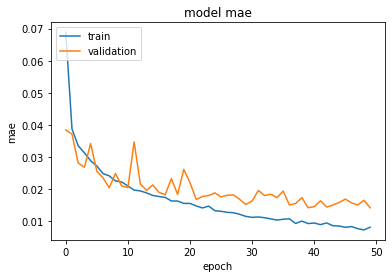

In [7]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

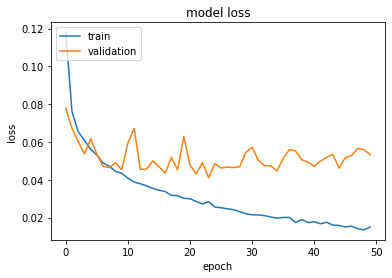

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

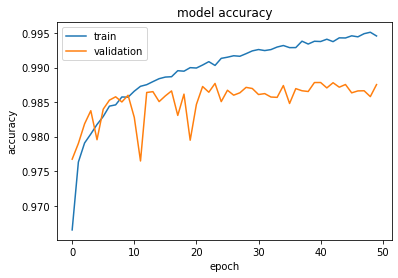

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
scores = majorityVoteModel.evaluate(X_test, Y_test)

32/32 [==============================] - 8s 239ms/step - loss: 0.3659 - mae: 0.0143 - accuracy: 0.9177


# Prediction der Challenge-Daten

In [47]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

3000it [00:41, 71.87it/s]


In [ ]:
challengePrediction = majorityVoteModel.predict(X_challenge)

In [67]:
df = bbdc.getPredictionAsSequenceDF(challengePrediction, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/majorityVoteUNet_challenge.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
from scipy.io.wavfile import read
fs = 16000

11233_mix.wav


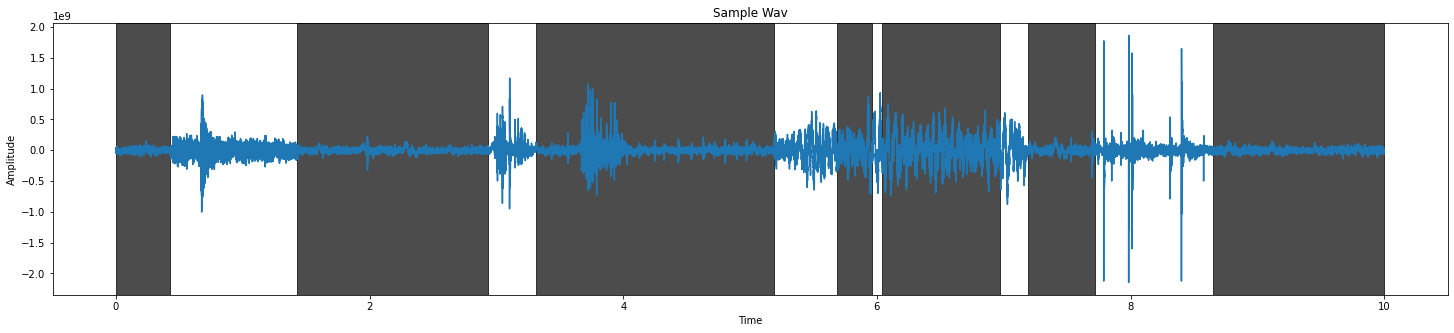

In [81]:
index = 1232
print(challengeFileList[index])
plt.figure(figsize=(25,5))
# read audio samples
input_data = read("../data/final_pre_dataset/eval/"+challengeFileList[index])
audio = input_data[1]
time=np.linspace(0, len(audio)/fs, num=len(audio))
plt.plot(time,audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sample Wav")

groups = bbdc.groupSequences(challengePrediction[index], timepoints)
for group in groups:
    if group[0][0]==0:
        onset = group[0][1]
        offset = group[-1][1]
        plt.axvspan(onset, offset, alpha=0.7, color='black', ymin=0, ymax=1)

plt.show()